# Covid_19 Prediction and future Forecasting using LSTM


The dataset used contains statewise data of the number of confirmed cases, deaths and new cases of Covid 19 in India from 31st January, 2020 to June 8th, 2021.


> # Objectives


  

*   The aim of the model is to use the historical data to forecast the number of Active cases for the next 30 days.
*   The below code uses a deep learning technique called as Long Short Term Memory(LSTM) as a regressor for predicting the number of active cases of covid 19.










> # Table of Contents


1.   Preprocessing the data 
2.   Fit the LSTM model
3.   Make predictions 
4.   Evaluate the performance of the model
5.   Forecast the data for upcoming 30 days






In [ ]:
#Importing the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

Number of Active cases is calculated from the dataset as follows $Active= Confirmed-Cured-Deaths$

In [ ]:
#Obtaining df0 = pd.read_csv("covid_19_india.csv")
df0['Active'] = df0['Confirmed'] - df0['Cured'] - df0['Deaths']
df0.tail() 
df0 = df0.drop(['Sno','ConfirmedIndianNational', 'ConfirmedForeignNational','Cured','Deaths'], axis=1)
df0.head()
print(df0)


             Date     Time State/UnionTerritory  Confirmed  Active
0      2020-01-30  6:00 PM               Kerala          1       1
1      2020-01-31  6:00 PM               Kerala          1       1
2      2020-02-01  6:00 PM               Kerala          2       2
3      2020-02-02  6:00 PM               Kerala          3       3
4      2020-02-03  6:00 PM               Kerala          3       3
...           ...      ...                  ...        ...     ...
15801  2021-06-08  8:00 AM            Telangana     593103   25406
15802  2021-06-08  8:00 AM              Tripura      56169    6018
15803  2021-06-08  8:00 AM          Uttarakhand     334419   14122
15804  2021-06-08  8:00 AM        Uttar Pradesh    1699083   15681
15805  2021-06-08  8:00 AM          West Bengal    1432019   26886

[15806 rows x 5 columns]


              Cases
Date               
2020-01-30        1
2020-01-31        1
2020-02-01        2
2020-02-02        3
2020-02-03        3
...             ...
2021-06-04  1635993
2021-06-05  1555248
2021-06-06  1477799
2021-06-07  1401609
2021-06-08  1303702

[496 rows x 1 columns]


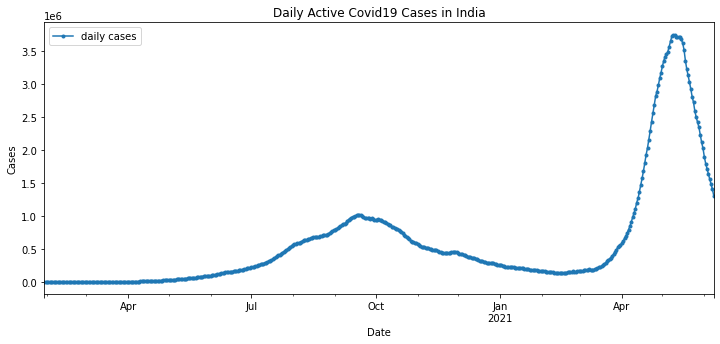

In [ ]:

count = []
for i in range(1,len(df0)):
    count.append(sum(pd.to_numeric(df0.iloc[i,4:].values)))

#Grouping the datewise active cases
df = pd.DataFrame()
df["Date"] = df0.Date
df.Date = pd.to_datetime(df0.Date)
df["Cases"] = df0["Active"]
df.sort_values(by="Date")
df1=df.groupby(["Date"]).sum()
print(df1)

df1.Cases.plot(title="Daily Active Covid19 Cases in India",marker=".",figsize=(12,5),label="daily cases")
plt.ylabel("Cases")
plt.legend()
plt.show()


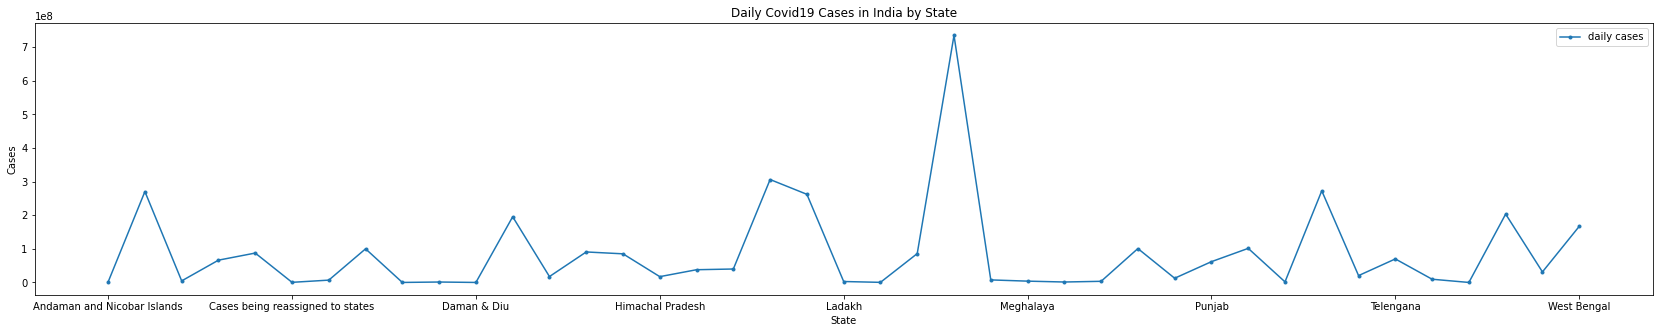

In [ ]:
#Active cases in India statewise
df2 = pd.DataFrame({"State":[],"Cases":[]})
df2["State"]=df0["State/UnionTerritory"][1:]
df2["Cases"]=df0["Confirmed"]
df2= df2.set_index("State")
df3=df2.groupby("State").sum()

df3.Cases.plot(title="Daily Covid19 Cases in India by State",marker=".",figsize=(29,5),label="daily cases")
plt.ylabel("Cases")
plt.legend()
plt.show()

In [ ]:
#Statewise active cases in India grouped by dates
df4 = pd.DataFrame()
df4["Date"] = df0["Date"][1:]
df4["Date"] = pd.to_datetime(df0["Date"])
df4["Cases"] =df0["Active"]
df4["State"] = df0["State/UnionTerritory"][1:]
df5=df4.groupby(["Date","State"]).sum()
print(df5)

                          Cases
Date       State               
2020-01-31 Kerala             1
2020-02-01 Kerala             2
2020-02-02 Kerala             3
2020-02-03 Kerala             3
2020-02-04 Kerala             3
...                         ...
2021-06-08 Telangana      25406
           Tripura         6018
           Uttar Pradesh  15681
           Uttarakhand    14122
           West Bengal    26886

[15805 rows x 1 columns]


LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [ ]:
# normalize the dataset
dataset=[]
for i in range(1,len(df1)):
  dataset.append(pd.to_numeric(df1.iloc[i,:1].values))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

With time series data, since the sequence of values is important, the ordered dataset is used to split into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 70% of the observations that we can use to train our model, leaving the remaining 30% for testing the model.

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

346 149


Now we can define a function to create a new dataset.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of covid active cases at a given time (t) and Y is the number of covid active cases at the next time (t + 1).

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 

# reshape train and test sets into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1 ))



We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, 2 hidden layers with 45 LSTM blocks or units each, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 500 epochs and a batch size of 150 is used.(The above mentioned hyperparameters were finalized after a series of trial and error of checking the performance of the model).

In [ ]:
# create and fit the LSTM network
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 45, return_sequences = True, input_shape = (trainX.shape[1], 1)))
#model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 45))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY,validation_data=(testX,testY), epochs=500, batch_size=150,verbose=1)

Epoch 1/500
3/3 [==============================] - 4s 480ms/step - loss: 0.0156 - val_loss: 0.2102
Epoch 2/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0134 - val_loss: 0.2001
Epoch 3/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.1902
Epoch 4/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0106 - val_loss: 0.1805
Epoch 5/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0090 - val_loss: 0.1711
Epoch 6/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0077 - val_loss: 0.1622
Epoch 7/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.1537
Epoch 8/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0069 - val_loss: 0.1457
Epoch 9/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.1389
Epoch 10/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0064 - val_loss: 0.1334
Epoch 11/500
3/3 [

Once the model is fit, we can estimate the performance of the model on the test dataset. We invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data.

RMSE and r2 score have been used as the performance metrics to evaluate the model performance.

In [ ]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('r2 score:',r2_score(testY[0], testPredict[:,0]))

Train Score: 8198.00 RMSE
Test Score: 61665.34 RMSE
r2 score: 0.9976272015233582


In [ ]:
df6=pd.DataFrame({'Actual':testY.reshape(-1),'predicted':testPredict.reshape(-1)})
print(df6)

        Actual     predicted
0     216558.0  2.216142e+05
1     214507.0  2.156936e+05
2     213603.0  2.136591e+05
3     213027.0  2.127625e+05
4     211033.0  2.121912e+05
..         ...           ...
143  1635993.0  1.725940e+06
144  1555248.0  1.647213e+06
145  1477799.0  1.565107e+06
146  1401609.0  1.486365e+06
147  1303702.0  1.408928e+06

[148 rows x 2 columns]


The data is plotted, showing the original dataset in blue, the predictions for the training dataset in orange, and the predictions on the unseen test dataset in green.

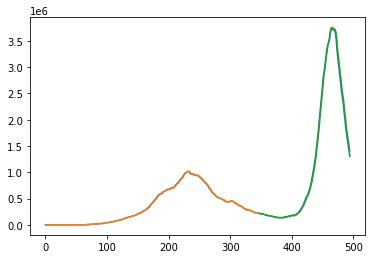

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [ ]:
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))
testX=scaler.inverse_transform(testX)
print(testX)


In [ ]:
x_input=testX[147:]
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

The below code is used to future forecast the number of active Covid-19 cases in India from 9th June, 2021 to 8th July,2021. A lookback of 1 is applied to predict the next day cases.

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[3.2946353]
2
1 day input [3.2946353]
1 day output [[2.5743086]]
2 day input [2.57430863]
2 day output [[2.2124803]]
3 day input [2.21248031]
3 day output [[1.9875704]]
4 day input [1.98757041]
4 day output [[1.8314513]]
5 day input [1.8314513]
5 day output [[1.7154647]]
6 day input [1.71546471]
6 day output [[1.6252297]]
7 day input [1.62522972]
7 day output [[1.5526501]]
8 day input [1.55265009]
8 day output [[1.49278]]
9 day input [1.49277997]
9 day output [[1.44241]]
10 day input [1.44240999]
10 day output [[1.3993552]]
11 day input [1.39935517]
11 day output [[1.362071]]
12 day input [1.36207104]
12 day output [[1.3294317]]
13 day input [1.32943165]
13 day output [[1.3005936]]
14 day input [1.30059361]
14 day output [[1.2749128]]
15 day input [1.27491283]
15 day output [[1.2518867]]
16 day input [1.25188673]
16 day output [[1.2311169]]
17 day input [1.23111689]
17 day output [[1.2122837]]
18 day input [1.21228373]
18 day output [[1.1951263]]
19 day input [1.1951263]
19 day output 

The predicted is inversed in order to match the format of the original dataset.


In [ ]:
#Forecast of active cases for the next 30 days
df6 = pd.DataFrame()
df6["Date"]=['09-06-2021','10-06-2021','11-06-2021','12-06-2021','13-06-2021','14-06-2021',
             '15-06-2021','16-06-2021','17-06-2021','18-06-2021','19-06-2021','20-06-2021',
             '21-06-2021','22-06-2021','23-06-2021','24-06-2021','25-06-2021','26-06-2021',
             '27-06-2021','28-06-2021','29-06-2021','30-06-2021','01-07-2021','02-07-2021',
             '03-07-2021','04-07-2021','05-07-2021','06-07-2021','07-07-2021','08-07-2021']
df6["Cases for next 30 days"] = scaler.inverse_transform(lst_output)
print(df6)


          Date  Cases for next 30 days
0   09-06-2021            1.233919e+07
1   10-06-2021            9.641394e+06
2   11-06-2021            8.286262e+06
3   12-06-2021            7.443921e+06
4   13-06-2021            6.859218e+06
5   14-06-2021            6.424821e+06
6   15-06-2021            6.086870e+06
7   16-06-2021            5.815042e+06
8   17-06-2021            5.590814e+06
9   18-06-2021            5.402167e+06
10  19-06-2021            5.240916e+06
11  20-06-2021            5.101278e+06
12  21-06-2021            4.979036e+06
13  22-06-2021            4.871031e+06
14  23-06-2021            4.774850e+06
15  24-06-2021            4.688612e+06
16  25-06-2021            4.610824e+06
17  26-06-2021            4.540290e+06
18  27-06-2021            4.476031e+06
19  28-06-2021            4.417246e+06
20  29-06-2021            4.363266e+06
21  30-06-2021            4.313531e+06
22  01-07-2021            4.267567e+06
23  02-07-2021            4.224968e+06
24  03-07-2021           